In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '6'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer, LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from feature_engine.discretisation import DecisionTreeDiscretiser

import warnings
warnings.filterwarnings('ignore')

from scripts.path import return_path
PATH = return_path() + 'wine_quality_data/'

## READ DATA

In [2]:
df = pd.read_csv(os.path.join(PATH, 'winequality.csv'), sep=';')
print(df.shape)
display(df.head())

(1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,total sulfur dioxide.1,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


# DATA CLEANING

## REMOVE NA

In [3]:
df2 = df.copy() # Copy
print('Before\n' + str(df2.isnull().sum()))

Before
fixed acidity             0
volatile acidity          0
citric acid               0
residual sugar            0
chlorides                 0
free sulfur dioxide       0
total sulfur dioxide      0
density                   0
pH                        0
sulphates                 0
total sulfur dioxide.1    0
quality                   0
dtype: int64


## REMOVE DUPLICATED

In [4]:
df = df2.copy()
print('Before =', any(df.duplicated()), '\nLength =', len(df))
df.drop_duplicates(keep='first', inplace=True)
print('\nAfter =', any(df.duplicated()), '\nLength =', len(df))
df = df.reset_index(drop=True)
display(df.head())

Before = True 
Length = 1599

After = False 
Length = 1359


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,total sulfur dioxide.1,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5


## DETECT OUTLIERS

### DBSCAN

In [5]:
# Source: https://towardsdatascience.com/practical-implementation-of-outlier-detection-in-python-90680453b3ce
from sklearn.cluster import DBSCAN

def remove_outliers_DBSCAN(df, eps, min_samples):
    outlier_detection = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = outlier_detection.fit_predict(df.values.reshape(-1, 1))
    data = pd.DataFrame()
    data['cluster'] = clusters
    return data['cluster']

clusters = remove_outliers_DBSCAN(df['total sulfur dioxide'], 0.5, 2)
clusters.value_counts().sort_values(ascending=False)

df_cluster = pd.DataFrame(clusters)
df_cluster.index = np.arange(1, len(df_cluster) + 1)
ind_outlier = df_cluster.index[df_cluster['cluster'] == -1]
print('outliers =', ', '.join([str(x) for x in ind_outlier]))
print('outlier values =', ', '.join([str(df.loc[x-1, 'total sulfur dioxide']) for x in ind_outlier]))

outliers = 81, 85, 100, 139, 171, 310, 457, 458, 514, 565, 593, 643, 684, 919, 921, 1061, 1327
outlier values = 136.0, 140.0, 153.0, 128.0, 126.0, 165.0, 142.0, 116.0, 149.0, 155.0, 152.0, 139.0, 130.0, 278.0, 289.0, 160.0, 131.0


### DIMENSION REDUCTION

In [6]:
pca = PCA(n_components=2, random_state=42)
df_pca = pd.DataFrame(data=pca.fit_transform(df), columns=['x1', 'x2'])

for columns in df.columns:
    df_pca[columns] = df[columns]
outlier_list = [True if x+1 in ind_outlier else False for x in range(len(df_pca))]
df_pca['outlier'] = outlier_list
df['outlier'] = outlier_list
    
print('There were', len([x for x in outlier_list if x is True]), 'outliers')
print(df.shape)
display(df.head())

There were 17 outliers
(1359, 13)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,total sulfur dioxide.1,quality,outlier
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,False
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,False
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,False
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,False
4,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5,False


In [7]:
fig = px.scatter(df_pca, x='x1', y='x2', hover_data=[df_pca.index] + [x for x in df_pca.columns],
        color='outlier',
        color_discrete_sequence=px.colors.qualitative.T10,
        title='Wine Quality Scatter Plot')
fig.show()

# DATA TRANSFORMATION

## BINNING

In [8]:
df = df.copy()
min_quality = df['quality'].min()
max_quality = df['quality'].max()
print('min quality =', min_quality)
print('max quality =', max_quality)

bins = np.linspace(min_quality, max_quality, 6)
print('bins =', bins)

labels = ['%X' % x for x in range(0xA, 0xF)]
print('labels =', labels)

min quality = 3
max quality = 8
bins = [3. 4. 5. 6. 7. 8.]
labels = ['A', 'B', 'C', 'D', 'E']


(1359, 14)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,total sulfur dioxide.1,quality,outlier,bins
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,False,B
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,False,B
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,False,B
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,False,C
4,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5,False,B


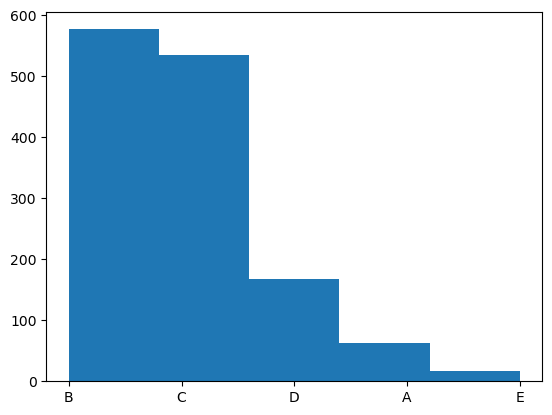

In [9]:
df['bins'] = pd.cut(df['quality'], bins=bins, labels=labels, include_lowest=True)
bins_list = df['bins']
print(df.shape)
display(df.head())

plt.hist(df['bins'], bins=5)
plt.show()

## LABEL ENCODING

In [10]:
df2 = df.copy()
columns = list(df2.columns)

for column in columns:
    if str(df[column].dtypes) in ['bool', 'category', 'object']:
        df2[column] = LabelEncoder().fit_transform(df2[column]).astype('float64')

print(df2.shape)
display(df2.head())

(1359, 14)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,total sulfur dioxide.1,quality,outlier,bins
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0.0,1.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0.0,1.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0.0,1.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0.0,2.0
4,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5,0.0,1.0


# DATA NORMALIZATION

## MINMAXSCALER

In [11]:
df_minmax = pd.DataFrame()
minmax = MinMaxScaler(feature_range=(0, 1)).fit_transform(df2[columns])

for index, column in enumerate(columns):
    df_minmax[column] = minmax[:, index]

print(df_minmax.shape)
display(df_minmax.head())

(1359, 14)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,total sulfur dioxide.1,quality,outlier,bins
0,0.247788,0.397260,0.00,0.068493,0.106845,0.140845,0.098940,0.567548,0.606299,0.137725,0.153846,0.4,0.0,0.25
1,0.283186,0.520548,0.00,0.116438,0.143573,0.338028,0.215548,0.494126,0.362205,0.209581,0.215385,0.4,0.0,0.25
2,0.283186,0.438356,0.04,0.095890,0.133556,0.197183,0.169611,0.508811,0.409449,0.191617,0.215385,0.4,0.0,0.25
3,0.584071,0.109589,0.56,0.068493,0.105175,0.225352,0.190813,0.582232,0.330709,0.149701,0.215385,0.6,0.0,0.50
4,0.247788,0.369863,0.00,0.061644,0.105175,0.169014,0.120141,0.567548,0.606299,0.137725,0.153846,0.4,0.0,0.25


## ZSCORE

In [12]:
df_zscore = pd.DataFrame()
df_zscore[columns] = zscore(df2[columns])

print(df_zscore.shape)
display(df_zscore.head())

(1359, 14)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,total sulfur dioxide.1,quality,outlier,bins
0,-0.524431,0.932000,-1.393258,-0.461157,-0.245623,-0.468554,-0.384050,0.584003,1.291872,-0.578561,-0.954374,-0.757040,-0.112551,-0.784303
1,-0.294063,1.915800,-1.393258,0.056665,0.200094,0.872003,0.604073,0.048737,-0.708395,0.124822,-0.584575,-0.757040,-0.112551,-0.784303
2,-0.294063,1.259934,-1.188617,-0.165259,0.078535,-0.085537,0.214813,0.155790,-0.321247,-0.051024,-0.584575,-0.757040,-0.112551,-0.784303
3,1.664067,-1.363534,1.471711,-0.461157,-0.265883,0.105971,0.394471,0.691057,-0.966495,-0.461331,-0.584575,0.457621,-0.112551,0.459417
4,-0.524431,0.713378,-1.393258,-0.535132,-0.265883,-0.277045,-0.204391,0.584003,1.291872,-0.578561,-0.954374,-0.757040,-0.112551,-0.784303


## DECIMAL SCALING

In [13]:
df_dscaling = pd.DataFrame()

for index, column in enumerate(columns):
    df_dscaling[column] = df2[column]/10**5

print(df_dscaling.shape)
display(df_dscaling.head())

(1359, 14)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,total sulfur dioxide.1,quality,outlier,bins
0,0.000074,0.000007,0.000000e+00,0.000019,7.600000e-07,0.00011,0.00034,0.00001,0.000035,0.000006,0.000094,0.00005,0.0,0.00001
1,0.000078,0.000009,0.000000e+00,0.000026,9.800000e-07,0.00025,0.00067,0.00001,0.000032,0.000007,0.000098,0.00005,0.0,0.00001
2,0.000078,0.000008,4.000000e-07,0.000023,9.200000e-07,0.00015,0.00054,0.00001,0.000033,0.000007,0.000098,0.00005,0.0,0.00001
3,0.000112,0.000003,5.600000e-06,0.000019,7.500000e-07,0.00017,0.00060,0.00001,0.000032,0.000006,0.000098,0.00006,0.0,0.00002
4,0.000074,0.000007,0.000000e+00,0.000018,7.500000e-07,0.00013,0.00040,0.00001,0.000035,0.000006,0.000094,0.00005,0.0,0.00001


# DISCRETIZATION

## EQUAL WIDTH

In [14]:
df_ewd = pd.DataFrame()
ewd = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')

df_ewd[columns] = ewd.fit_transform(np.array(df2[columns]))
print(df_ewd.shape)
display(df_ewd.head())

(1359, 14)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,total sulfur dioxide.1,quality,outlier,bins
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,0.0,0.0,2.0,0.0,1.0
1,1.0,2.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,0.0,1.0
2,1.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,1.0,2.0,0.0,1.0
3,2.0,0.0,2.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,1.0,3.0,0.0,2.0
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,0.0,0.0,2.0,0.0,1.0


In [15]:
fig = px.box(df_ewd, title='Equal Width Box Plot')
fig.show()

## EQUAL FREQUENCY

In [16]:
df_efd = pd.DataFrame()
efd = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')

df_efd[columns] = efd.fit_transform(np.array(df2[columns]))
print(df_efd.shape)
display(df_efd.head())

(1359, 14)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,total sulfur dioxide.1,quality,outlier,bins
0,1.0,4.0,0.0,1.0,2.0,2.0,2.0,3.0,4.0,1.0,0.0,1.0,0.0,1.0
1,2.0,4.0,0.0,3.0,4.0,4.0,3.0,2.0,1.0,3.0,1.0,1.0,0.0,1.0
2,2.0,4.0,0.0,3.0,3.0,2.0,3.0,2.0,1.0,3.0,1.0,1.0,0.0,1.0
3,4.0,0.0,4.0,1.0,1.0,3.0,3.0,3.0,0.0,1.0,1.0,2.0,0.0,2.0
4,1.0,3.0,0.0,1.0,1.0,2.0,2.0,3.0,4.0,1.0,0.0,1.0,0.0,1.0


In [17]:
fig = px.box(df_efd, title='Equal Frequency Box Plot')
fig.show()

## KMEANS

In [18]:
df_kmd = pd.DataFrame()
kmd = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans')

df_kmd[columns] = kmd.fit_transform(np.array(df2[columns]))
print(df_kmd.shape)
display(df_kmd.head())

(1359, 14)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,total sulfur dioxide.1,quality,outlier,bins
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0
1,0.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
3,2.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0


In [19]:
fig = px.box(df_kmd, title='K Means Box Plot')
fig.show()

## DECISION TREE

In [20]:
columns_x = [x for x in columns if x != 'quality']

df_dtd = pd.DataFrame()
x = pd.DataFrame(df2[columns_x], dtype='str')
y = pd.Series(df2['quality'], dtype='str')

for column in columns_x:
    dtd = DecisionTreeDiscretiser(random_state=42, variables=[column], scoring='neg_mean_squared_error', regression=False)
    df_dtd[column] = dtd.fit_transform(df2[[column]], y)
df_dtd['quality'] = y

print(df_dtd.shape)
display(df_dtd.head())

(1359, 14)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,total sulfur dioxide.1,outlier,bins,quality
0,0.040286,0.045537,0.054594,0.024752,0.037037,0.045929,0.041812,0.038229,0.055844,0.062059,0.042899,0.039493,0.0,5
1,0.040286,0.222222,0.054594,0.013889,0.033755,0.022444,0.041812,0.038229,0.016978,0.013846,0.042899,0.039493,0.0,5
2,0.040286,0.045537,0.054594,0.039735,0.037037,0.045929,0.041812,0.038229,0.016978,0.013846,0.042899,0.039493,0.0,5
3,0.028708,0.010417,0.019737,0.024752,0.037037,0.045929,0.041812,0.038229,0.016978,0.062059,0.042899,0.039493,0.0,6
4,0.040286,0.045537,0.054594,0.024752,0.037037,0.045929,0.041812,0.038229,0.055844,0.062059,0.042899,0.039493,0.0,5


In [21]:
fig = px.box(df_dtd.drop(['quality'], axis=1), title='Decision Tree Box Plot')
fig.show()

# ORIGINAL VS. NORMALIZED VS. DISCRETIZED VISUALIZATION

Quality


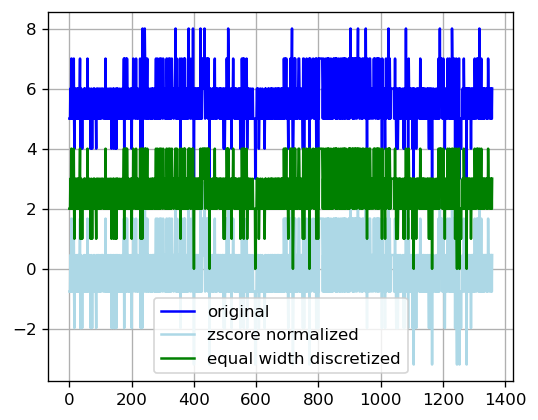

In [22]:
print('Quality')
fig = plt.figure(figsize=[5, 4], dpi=120)
plt.grid()
plt.plot(df2['quality'], label='original', color='blue')
plt.plot(df_zscore['quality'], label='zscore normalized', color='lightblue')
plt.plot(df_ewd['quality'], label='equal width discretized', color='green')
plt.legend()
plt.show()

total sulfur dioxide


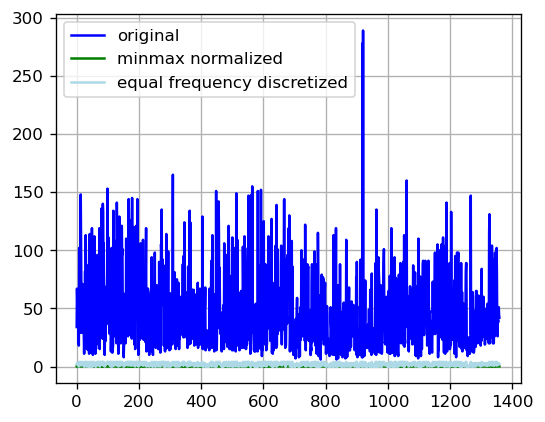

In [23]:
print('total sulfur dioxide')
fig = plt.figure(figsize=[5, 4], dpi=120)
plt.grid()
plt.plot(df2['total sulfur dioxide'], label='original', color='blue')
plt.plot(df_minmax['total sulfur dioxide'], label='minmax normalized', color='green')
plt.plot(df_efd['total sulfur dioxide'], label='equal frequency discretized', color='lightblue')
plt.legend()
plt.show()

# DATA REDUCTION


In [24]:
def principal_component_analysis(df):
    x = pd.DataFrame(df[[x for x in columns if x != 'quality']])
    y = pd.DataFrame(df[['quality']])
    x_pca = PCA(n_components=5, random_state=42).fit_transform(x)
    x_pca = pd.DataFrame(data=x_pca, columns=['f1', 'f2', 'f3', 'f4', 'f5'])
    x_pca['quality'] = y
    display(x_pca.head())

def principal_component_analysis_visualization(df, name):
    x = pd.DataFrame(df[[x for x in columns if x != 'quality']])
    y = pd.DataFrame(df[['quality']])
    x_pca = PCA(n_components=2, random_state=42).fit_transform(x)
    x_pca = pd.DataFrame(data=x_pca, columns=['f1', 'f2'])
    for column in df.columns:
        x_pca[column] = df[column]

    fig = px.scatter(x_pca, x='f1', y='f2', hover_data=[x_pca.index] + [x for x in x_pca.columns],
        color='quality',
        color_discrete_sequence=px.colors.qualitative.T10,
        title=f'{name} Wine Quality Scatter Plot')
    # fig.show()

## ORIGINAL DATA

In [25]:
principal_component_analysis(df2)
principal_component_analysis_visualization(df2, 'Original')

,f1,f2,f3,f4,f5,quality
0,-13.567219,-2.025180,-1.149015,-0.697321,1.118633,5
1,21.668603,4.550971,-0.346623,-0.313611,0.730111,5
2,6.821879,-2.419270,-0.605535,-0.395478,0.683783,5
3,13.084683,-1.821561,2.735025,-1.391685,-0.307679,6
4,-7.278908,-1.362177,-1.136124,-0.832869,1.022997,5


## NORMALIZED DATA

### MINMAX

In [26]:
principal_component_analysis(df_minmax)
principal_component_analysis_visualization(df_minmax, 'MinMax')

,f1,f2,f3,f4,f5,quality
0,-0.353837,-0.130559,-0.145898,-0.107677,0.018789,0.4
1,-0.313624,-0.175314,0.061735,-0.108750,0.094624,0.4
2,-0.268172,-0.147975,-0.058533,-0.067441,0.045164,0.4
3,0.410624,-0.137932,0.032201,-0.018962,-0.058364,0.6
4,-0.349453,-0.132151,-0.111324,-0.105777,0.006266,0.4


### ZSCORE

In [27]:
principal_component_analysis(df_zscore)
principal_component_analysis_visualization(df_zscore, 'Z-Score')

,f1,f2,f3,f4,f5,quality
0,-1.773189,1.009452,-1.495006,-0.122990,0.089849,-0.757040
1,-0.941300,2.002563,-0.345103,0.484212,0.302834,-0.757040
2,-0.885047,1.286378,-0.885170,0.283323,0.054721,-0.757040
3,2.401647,-0.218032,0.081834,-0.867344,-1.298767,0.457621
4,-1.730395,1.061828,-1.269482,-0.098642,-0.040279,-0.757040


### DECIMAL SCALING

In [28]:
principal_component_analysis(df_dscaling)
principal_component_analysis_visualization(df_dscaling, 'Decimal Scaling')

,f1,f2,f3,f4,f5,quality
0,-0.000136,-0.000020,-0.000011,-0.000007,0.000011,0.00005
1,0.000217,0.000046,-0.000003,-0.000003,0.000007,0.00005
2,0.000068,-0.000024,-0.000006,-0.000004,0.000007,0.00005
3,0.000131,-0.000018,0.000027,-0.000014,-0.000003,0.00006
4,-0.000073,-0.000014,-0.000011,-0.000008,0.000010,0.00005


## DISCRETIZED DATA

### EQUAL WIDTH

In [29]:
principal_component_analysis(df_ewd)
principal_component_analysis_visualization(df_ewd, 'Equal Width')

,f1,f2,f3,f4,f5,quality
0,-1.299849,-0.980133,-0.806203,-0.452999,-0.120680,2.0
1,-0.773652,-0.830446,0.458824,0.636574,0.692176,2.0
2,-1.239018,-0.601191,-0.949093,0.649667,0.224996,2.0
3,1.556621,0.140409,0.250168,-0.185258,-0.287127,3.0
4,-1.299849,-0.980133,-0.806203,-0.452999,-0.120680,2.0


### EQUAL FREQUENCY

In [30]:
principal_component_analysis(df_efd)
principal_component_analysis_visualization(df_efd, 'Equal Frequency')

,f1,f2,f3,f4,f5,quality
0,2.728707,-2.519661,-1.618188,0.590415,-1.285108,1.0
1,0.277575,-3.294785,0.382769,-0.665939,-0.884645,1.0
2,0.394325,-2.358075,-0.654046,-0.579394,-0.826279,1.0
3,-3.118503,0.133973,1.126211,2.990583,1.352048,2.0
4,2.669213,-1.775659,-1.134531,0.948497,-1.047295,1.0


### KMEANS

In [31]:
principal_component_analysis(df_kmd)
principal_component_analysis_visualization(df_kmd, 'K-Means')

,f1,f2,f3,f4,f5,quality
0,-1.602832,-0.405868,-0.632503,-0.239666,0.822520,1.0
1,-1.054049,-1.151612,0.417559,0.658551,-1.047412,1.0
2,-1.570583,-0.813103,-0.899747,0.206807,-0.306864,1.0
3,1.805664,-0.572734,0.213857,-0.337629,-0.317893,1.0
4,-1.602832,-0.405868,-0.632503,-0.239666,0.822520,1.0


### DECISION TREE

In [32]:
principal_component_analysis(df_dtd)
principal_component_analysis_visualization(df_dtd, 'Decision Tree')

,f1,f2,f3,f4,f5,quality
0,-0.037886,0.016827,-0.031771,0.002020,-0.009128,5
1,-0.027008,0.177997,0.044805,-0.047783,0.013038,5
2,-0.038941,0.006248,0.021639,-0.009783,0.002288,5
3,-0.041190,-0.025606,-0.017831,-0.003205,0.035271,6
4,-0.037886,0.016827,-0.031771,0.002020,-0.009128,5
